<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Bot de consulta abierta y respuestas predeterminadas con DNN + Spacy

#### Caso:

Se decide utilizar el Reglamento de la especialidad como fuente de conocimiento para el desarrollo de un bot de consulta.


### 1 - Instalar dependencias
Para poder utilizar Spacy en castellano es necesario agregar la librería "spacy-stanza" para lematizar palabras en español.

In [2]:
# La última versión de spacy-stanza (>1.0) es compatible solo con spacy >=3.0
# Nota: spacy 3.0 incorpora al pepiline nlp transformers
!pip install -U spacy==3.6.0 -qq
!pip install -U spacy-stanza -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 12.7 MB/s eta 0:00:00


In [47]:
import json
import string
import random
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchsummary

In [4]:
import os
import platform

if os.access('torch_helpers.py', os.F_OK) is False:
    if platform.system() == 'Windows':
        !curl !wget https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py > torch_helpers.py
    else:
        !wget torch_helpers.py https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py

--2023-11-14 21:30:52--  http://torch_helpers.py/
Resolving torch_helpers.py (torch_helpers.py)... failed: Name or service not known.
wget: unable to resolve host address ‘torch_helpers.py’
--2023-11-14 21:30:52--  https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23883 (23K) [text/plain]
Saving to: ‘torch_helpers.py’

torch_helpers.py    100%[===================>]  23.32K  --.-KB/s    in 0.002s  

2023-11-14 21:30:52 (10.0 MB/s) - ‘torch_helpers.py’ saved [23883/23883]

FINISHED --2023-11-14 21:30:52--
Total wall clock time: 0.2s
Downloaded: 1 files, 23K in 0.002s (10.0 MB/s)


In [5]:
# Se levanta el corpus compuesto de los 17 Artículos del Reglamento del posgrado
with open('./Reglamento.txt','r') as handle:
  texto = handle.read()

In [6]:
# Algo de pos-procesamiento
texto = '\n'+texto
textos = texto.split('\n')[1:]

In [7]:
textos

['Art. 1o Las asignaturas correspondientes al posgrado se organizan en 5 (cinco) bimestres corridos. A su vez se establece cada año una semana de vacaciones durante el mes de julio o agosto, coincidente con el receso escolar de invierno en Argentina.',
 'Art. 2° Las asignaturas que se ofrecen son de asistencia obligatoria y es condición de aprobación haber asistido a por lo menos el 75% de las clases de cada asignatura.',
 'Art. 3o Las asignaturas se aprueban con una nota mínima de 4 (cuatro). Al inicio de cada asignatura el docente establece si se aprueba mediante examen en la última clase y/o mediante la realización de un trabajo con fecha de entrega en la última clase, detallando además el criterio de aprobación y calificación correspondiente. El docente hará lo posible por informar la aprobación o desaprobación de su asignatura durante la semana siguiente a la finalización de la cursada. En su defecto, existen dos casos particulares a considerar: 1) Si el alumno debe cursar una asi

Se generan 10 preguntas para cada Artículo:

In [8]:
preguntas = """'Art.1':
¿Cuántos bimestres comprende la organización de las asignaturas en el posgrado?
¿Cuántas semanas de vacaciones se establecen cada año?
¿En qué meses se programan las vacaciones para los estudiantes del posgrado?
¿Cuál es la duración de cada bimestre en el posgrado?
¿En qué país se establece el receso escolar de invierno mencionado?
¿Cuántos años se repite la programación de las vacaciones en el posgrado?
¿Qué tipo de asignaturas se mencionan en el párrafo?
¿Cómo se organiza el calendario académico de las asignaturas en el posgrado?
¿En qué período del año ocurre el receso escolar de invierno en Argentina?
¿Cuál es la finalidad de establecer una semana de vacaciones coincidente con el receso escolar de invierno?

'Art.2':
¿Cuál es el contenido del Artículo 2 en relación con las asignaturas ofrecidas?
¿Qué requisito se establece para aprobar las asignaturas mencionadas en el artículo?
¿Cuál es el porcentaje mínimo de asistencia requerido para aprobar una asignatura?
¿Qué se entiende por "asistencia obligatoria" en este contexto?
¿Qué consecuencias puede tener no cumplir con el requisito de asistencia obligatoria?
¿Cómo se mide la asistencia a las clases de una asignatura?
¿Qué se considera como aprobación de una asignatura según el Artículo 2?
¿Se mencionan excepciones a la asistencia obligatoria en el párrafo?
¿Qué tipo de asignaturas se refieren en este artículo?
¿Cuál es el propósito de establecer la asistencia obligatoria en las asignaturas ofrecidas?

'Art.3':
¿Cuál es la nota mínima requerida para aprobar una asignatura según el Artículo 3?
¿Cómo se decide el método de aprobación de una asignatura al comienzo de la misma?
¿Cuándo se espera que el docente informe sobre la aprobación o desaprobación de una asignatura?
¿Qué ocurre si un alumno debe cursar una asignatura correlativa?
¿Qué sucede si un estudiante desaprueba una asignatura y alcanza tres aplazos?
¿Qué se entiende por "cursada" en el contexto del artículo?
¿Qué detalles se espera que el docente proporcione sobre el criterio de aprobación?
¿Quién tiene la autoridad para resolver la situación de un estudiante que alcanza tres aplazos?
¿Cuál es la importancia de la fecha de entrega en el proceso de aprobación?
¿Qué medidas se toman para los estudiantes que deben cursar una asignatura correlativa en caso de desaprobación?

'Art.4':
¿Qué sucede si un alumno no cumple con los requisitos establecidos en los Artículos 2 y 3?
¿Cómo se calificará a un estudiante que no cumple con los requisitos mencionados?
¿Cuál es la consecuencia de ser calificado como "Aplazado"?
¿Qué se requiere para evitar ser calificado como "Aplazado"?
¿Se proporciona alguna oportunidad para los estudiantes calificados como "Aplazado"?
¿Puede un estudiante volver a cursar la misma asignatura en una cohorte posterior?
¿Cuáles son los criterios para ser considerado "aprobado" en una asignatura?
¿Hay un límite en la cantidad de veces que un estudiante puede volver a cursar la misma asignatura?
¿Qué se entiende por "cohorte posterior" en este contexto?
¿Se establecen condiciones especiales para los estudiantes calificados como "Aplazado" que deseen volver a cursar la asignatura?

'Art.5':
¿Hasta qué clase un alumno puede solicitar la baja de una asignatura sin recibir un aplazo?
¿Qué acción debe tomar un estudiante si desea darse de baja de una asignatura antes de la clase 4?
¿A quiénes debe notificar un alumno si desea darse de baja de una asignatura?
¿Cómo se considera fehaciente el aviso de baja de una asignatura?
¿Qué se requiere para que el aviso de baja sea considerado válido?
¿Qué sucede si un alumno recibe un acuse de recibo de Gestión Académica tras solicitar la baja de una asignatura?
¿En qué momento se aplica el Artículo 4 si un alumno se da de baja de una asignatura después de la clase 3?
¿Se pueden hacer excepciones al Artículo 4 si un estudiante cumple con el criterio de aprobación?
¿Cuál es el propósito de permitir la baja de una asignatura antes de la clase 4 sin aplazo?
¿Se menciona algún proceso adicional o requisito para la baja de una asignatura en el artículo?

'Art.6':
¿Cuántos bimestres corridos tiene un estudiante para recursar asignaturas sin costo adicional?
¿A partir de qué punto se considera que comienza el período de los 10 bimestres para la recursada?
¿Qué requisitos debe cumplir un estudiante para ser elegible para la recursada sin costo adicional?
¿Cuál es el propósito de completar los pagos de las cuotas correspondientes a la cohorte?
¿Cuántos aplazos se pueden acumular antes de no ser elegible para la recursada sin costo adicional?
¿En qué circunstancias un estudiante quedará libre por la acumulación de 3 aplazos?
¿La opción de recursar sin costo adicional se aplica solo a maestrías específicas?
¿Existen restricciones en cuanto a la cantidad de asignaturas que un estudiante puede recursar en este período?
¿Qué se considera "tiempo y forma" en términos de los pagos de las cuotas de la cohorte?
¿Se proporciona alguna información adicional sobre el procedimiento para solicitar la recursada sin costo adicional en el artículo?

'Art.7':
¿Cuál es el límite de tiempo para la aprobación de todas las asignaturas y el Trabajo Final en el posgrado?
¿Qué sucede una vez que un estudiante alcanza los 10 bimestres corridos sin cumplir con los requisitos de aprobación?
¿Cuántos aplazos se deben acumular para quedar libre de acuerdo con el Artículo 7?
¿Qué opciones tiene un estudiante que queda libre y no puede continuar cursando?
¿Qué acciones debe tomar un alumno si desea continuar sus estudios después de quedar libre?
¿Qué implica comenzar de nuevo en términos de abonar los aranceles correspondientes?
¿Un estudiante puede completar un Trabajo Final que hubiera comenzado previamente después de quedar libre?
¿Existe alguna alternativa para un estudiante que no pueda cumplir con los requisitos de aprobación en 10 bimestres?
¿Qué se entiende por "totalidad de las asignaturas de la misma" en el contexto del artículo?
¿Hay alguna disposición adicional relacionada con el proceso de comenzar de nuevo en el artículo?

'Art.8':
¿Cuál es el momento ideal para presentar el Trabajo Final de acuerdo con el Artículo 8?
¿Qué requisitos debe cumplir un estudiante que desee comenzar su Trabajo Final en el primer bimestre?
¿Qué asignaturas debe cursar un estudiante que opta por empezar su Trabajo Final en el primer bimestre?
¿Qué opciones tienen los estudiantes que no pueden definir su tema de Trabajo Final antes del primer bimestre?
¿En qué instancia se pueden presentar los Trabajos Finales que no fueron presentados al finalizar el quinto bimestre?
¿Cuál es el límite de tiempo para la presentación del Trabajo Final según el Artículo 8?
¿Existen restricciones adicionales para la presentación del Trabajo Final más allá del plazo de 10 bimestres?
¿Qué se entiende por "instancias del Taller de Trabajo Final" en el contexto del artículo?
¿Qué asignaturas específicas se mencionan como requisitos para comenzar el Trabajo Final?
¿Se proporciona alguna información adicional sobre el proceso de presentación del Trabajo Final en el artículo?

'Art.9':
¿Qué papel desempeña un director en la realización del Trabajo Final, según el Artículo 9?
¿Quién tiene la responsabilidad de proponer a un director para el Trabajo Final?
¿Qué requisitos se deben cumplir para que un director sea considerado adecuado?
¿Quién evalúa si el director propuesto por el alumno cumple con los requisitos adecuados?
¿Qué ocurre si un estudiante no propone un director con antecedentes adecuados?
¿Quién es el encargado de asignar un director de Trabajo Final si el alumno no hace una propuesta adecuada?
¿Qué criterios se utilizan para determinar si un director posee antecedentes adecuados?
¿Se proporciona alguna guía o criterio específico para la selección de un director?
¿Cómo se comunica la asignación de un director de Trabajo Final al alumno?
¿Hay alguna disposición adicional relacionada con la elección de un director en el artículo?

'Art.10':
¿Cuántas veces puede un alumno poner su Trabajo Final en pausa según el Artículo 10?
¿Cuál es la duración de cada período de pausa permitido?
¿Qué ventaja ofrece poner el Trabajo Final en pausa en términos de la comunicación con el director?
¿Cuál es el propósito principal de permitir las pausas en el Trabajo Final?
¿Qué sucede si un estudiante solicita los tres periodos de pausa disponibles?
¿Se menciona alguna restricción en cuanto a la solicitud de pausas adicionales después de utilizar las tres permitidas?
¿Las pausas afectan el plazo para la presentación del Trabajo Final?
¿Cómo se solicita una pausa en el Trabajo Final?
¿El director del Trabajo Final tiene algún papel específico en el proceso de pausa?
¿Existen otros detalles relevantes sobre el uso de las pausas en el artículo?

'Art.11':
¿Cuál es la razón por la cual un director podría solicitar ser relevado de su rol en el Trabajo Final, según el Artículo 11?
¿Qué consecuencias tiene para el alumno si el director solicita ser relevado por bajo desempeño?
¿Quién se encarga de asignar un nuevo director en caso de relevo?
¿Qué criterios se utilizan para determinar si el alumno no se compromete adecuadamente con su Trabajo Final?
¿Qué opciones tiene el nuevo director si también considera que el alumno no se compromete adecuadamente con su Trabajo Final?
¿Qué sucede si un estudiante queda libre debido a la renuncia de su director y no puede continuar cursando?
¿Se establecen procedimientos específicos para el relevo de un director en el artículo?
¿El alumno tiene la oportunidad de defenderse o presentar su perspectiva en caso de que el director solicite el relevo?
¿El artículo proporciona detalles sobre el proceso de asignación de un nuevo director?
¿Existen medidas adicionales relacionadas con el proceso de relevo de un director en el artículo?

'Art.12':
¿Cuándo debe un alumno presentar un informe de avance de su Trabajo Final, de acuerdo con el Artículo 12?
¿Quiénes componen el jurado encargado de evaluar el informe de avance?
¿Cuál es la responsabilidad del alumno con respecto a los comentarios del jurado sobre sus avances?
¿Qué se espera del alumno en respuesta a los comentarios del jurado?
¿En qué situaciones un estudiante debe presentar un informe de avance cada vez que curse el Taller de Trabajo Final?
¿Cuál es el propósito de presentar un informe de avance tres meses antes de la presentación del Trabajo Final?
¿El Artículo 12 establece algún mecanismo específico para presentar el informe de avance?
¿Se mencionan las fechas o plazos exactos para la presentación del informe de avance?
¿Cuál es la importancia de la evaluación por parte del jurado en el proceso del Trabajo Final?
¿Se proporciona información adicional sobre el proceso de presentación del informe de avance en el artículo?

'Art.13':
¿Qué se espera que haga un alumno al finalizar cada bimestre con respecto a las encuestas de evaluación de los cursos, según el Artículo 13?
¿Cómo se garantiza que los alumnos respondan estas encuestas de evaluación?
¿Qué sucede si un estudiante no cumple con la obligación de responder las encuestas?
¿Existen procesos específicos que se establecen para asegurar que los alumnos respondan las encuestas de evaluación?
¿Las encuestas de evaluación son anónimas para los estudiantes?
¿Qué se busca lograr con la obligación de responder las encuestas de evaluación?
¿Se mencionan las consecuencias de no responder las encuestas de evaluación en el artículo?
¿El artículo establece algún mecanismo para garantizar la confidencialidad de las respuestas de los estudiantes en las encuestas?
¿Se proporciona información adicional sobre el proceso de respuesta a las encuestas en el artículo?
¿Qué relación existe entre la respuesta a las encuestas de evaluación y la posibilidad de continuar cursando y presentar el Trabajo Final?

'Art.14':
¿Qué expectativa de comportamiento se espera de un alumno hacia los demás en el posgrado, según el Artículo 14?
¿Quiénes son considerados destinatarios de este trato respetuoso por parte del alumno?
¿Quién tiene la autoridad para evaluar si el trato de un alumno no es respetuoso?
¿Qué acciones toma el Coordinador o Director del posgrado en caso de un trato no respetuoso por parte del alumno?
¿Cuántas advertencias recibe un alumno en caso de comportamiento no respetuoso, según el artículo?
¿Se menciona alguna referencia específica al artículo en las advertencias?
¿Qué consecuencias tiene para el alumno la tercera situación de comportamiento no respetuoso?
¿Se proporciona información adicional sobre el proceso de advertencia y pérdida de regularidad en el artículo?
¿Qué se espera lograr con la exigencia de trato respetuoso en el posgrado?
¿Existe la posibilidad de que un alumno sea readmitido después de la pérdida de regularidad?

'Art.15':
¿Cuál es la posibilidad que tiene un alumno en relación con la consulta a los docentes, según el Artículo 15?
¿En qué temas o cuestiones específicas se permite que un estudiante consulte a los docentes?
¿Cuál es el papel del docente si considera que un alumno no comprende adecuadamente su explicación?
¿A quién debe informar el docente en caso de que crea que el alumno no comprende la explicación?
¿Quién tiene la autoridad para analizar la situación y tomar decisiones relacionadas con la consulta y comprensión del alumno?
¿Qué medidas puede tomar el Coordinador o Director del posgrado en función de la situación analizada?
¿Se establecen condiciones específicas para la realización de explicaciones adicionales por parte del docente?
¿El artículo menciona algún proceso formal para solicitar consultas o explicaciones adicionales?
¿Hay algún mecanismo de apelación si un estudiante no está satisfecho con la decisión del Coordinador o Director?
¿Se proporciona información adicional sobre la relación entre los alumnos y los docentes en el artículo?

'Art.16':
¿Cuándo un docente puede considerar que uno o más alumnos se copiaron en un examen individual, de acuerdo con el Artículo 16?
¿Qué opciones tiene un docente para abordar una situación en la que se sospecha que hubo copia en un examen individual?
¿Quién debe colaborar con el docente en la toma de decisiones respecto a la situación de copia?
¿Qué proceso debe seguir el docente para determinar la medida apropiada?
¿Cuál es el propósito de notificar a los alumnos involucrados en la situación?
¿Qué se espera de los alumnos involucrados en términos de hacer un descargo por escrito?
¿El descargo de los alumnos tiene un carácter vinculante?
¿Qué autoridades del posgrado están autorizadas para considerar el descargo de los alumnos involucrados?
¿Se mencionan detalles específicos sobre cómo se llevará a cabo la notificación y el proceso de decisión?
¿Existen disposiciones adicionales relacionadas con la prevención y manejo de situaciones de copia en el artículo?

'Art.17':
¿Qué tipo de situaciones de los alumnos pueden ser resueltas por el Consejo Académico del posgrado, según el Artículo 17?
¿En qué circunstancias se aplicará la intervención del Consejo Académico?
¿Quién tiene la autoridad para tomar decisiones en situaciones que no estén contempladas en el Reglamento?
¿Cuál es el proceso para resolver situaciones particulares de los alumnos a través del Consejo Académico?
¿Cómo se registra oficialmente la decisión tomada por el Consejo Académico?
¿Qué importancia tiene el acta del Consejo Académico en este proceso?
¿Se establece un plazo para la comunicación de la decisión tomada al alumno?
¿Los alumnos tienen la oportunidad de presentar sus argumentos o evidencia en el proceso?
¿Existen criterios específicos que guíen las decisiones del Consejo Académico en estas situaciones?
¿El artículo menciona algún mecanismo de apelación en caso de desacuerdo con la decisión del Consejo Académico?
"""



In [9]:
# Pos-procesamos el string de preguntas para generar un diccionario

preguntas1 = preguntas.split('Art.')[1:]
preguntas_dict = {}

for i,p in enumerate(preguntas1):
  p1 = p.split('\n')
  preguntas_dict[p1[0]] = p1[1:-2]

In [10]:
preguntas_dict

{"1': ": ['¿Cuántos bimestres comprende la organización de las asignaturas en el posgrado?',
  '¿Cuántas semanas de vacaciones se establecen cada año?',
  '¿En qué meses se programan las vacaciones para los estudiantes del posgrado?',
  '¿Cuál es la duración de cada bimestre en el posgrado?',
  '¿En qué país se establece el receso escolar de invierno mencionado?',
  '¿Cuántos años se repite la programación de las vacaciones en el posgrado?',
  '¿Qué tipo de asignaturas se mencionan en el párrafo?',
  '¿Cómo se organiza el calendario académico de las asignaturas en el posgrado?',
  '¿En qué período del año ocurre el receso escolar de invierno en Argentina?',
  '¿Cuál es la finalidad de establecer una semana de vacaciones coincidente con el receso escolar de invierno?'],
 "2': ": ['¿Cuál es el contenido del Artículo 2 en relación con las asignaturas ofrecidas?',
  '¿Qué requisito se establece para aprobar las asignaturas mencionadas en el artículo?',
  '¿Cuál es el porcentaje mínimo de a

In [14]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
sw = stopwords.words("spanish")
len(sw)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


313

In [15]:
import stanza
import spacy_stanza

# Vamos a usar SpaCy-Stanza. Stanza es una librería de NLP de Stanford
# SpaCy armó un wrapper para los pipelines y modelos de Stanza
# https://stanfordnlp.github.io/stanza/

# Descargar el diccionario en español y armar el pipeline de NLP con spacy
stanza.download("es")
nlp = spacy_stanza.load_pipeline("es")

INFO:stanza:Downloading default packages for language: es (Spanish) ...


INFO:stanza:Finished downloading models and saved to /root/stanza_resources.
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: es (Spanish):
| Processor    | Package         |
----------------------------------
| tokenize     | ancora          |
| mwt          | ancora          |
| pos          | ancora_charlm   |
| lemma        | ancora_nocharlm |
| constituency | combined_charlm |
| depparse     | ancora_charlm   |
| sentiment    | tass2020        |
| ner          | conll02         |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: constituency
INFO:stanza:Loading: depparse
INFO:stanza:Loading: sentiment
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!


### 2 - Herramientas de preprocesamiento de datos
Entre las tareas de procesamiento de texto en español se implementa:
- Quitar acentos y caracteres especiales
- Quitar números
- Quitar símbolos de puntuación
- Quitar stop-words

In [41]:
import re
import unicodedata

# El preprocesamento en castellano requiere más trabajo

# Referencia de regex:
# https://docs.python.org/3/library/re.html

def preprocess_clean_text(text):
    # sacar tildes de las palabras
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # quitar caracteres especiales
    pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]'
    text = re.sub(pattern, '', text)
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]'
    # quitar números
    text = re.sub(pattern, '', text)
    # quitar caracteres de puntiación
    text = ''.join([c for c in text if c not in string.punctuation])# and c not in sw])
    return text

In [42]:
text = "personas Ideas! estás cosas y los peces y los muercielagos"

# Antes de preprocesar los datos se pasa a mínusculas todo el texto
preprocess_clean_text(text.lower())

'personas ideas estas cosas y los peces y los muercielagos'

In [43]:
# Ejemplo de como fuciona
text = "hola personas Ideas! estás cosas y los peces y los muercielagos"

# Antes de preprocesar los datos se pasa a mínusculas todo el texto
tokes = nlp(preprocess_clean_text(text.lower()))
print("tokens:", tokes)
print("Lematización de cada token:")
for token in tokes:
    print([token, token.lemma_])

tokens: hola personas ideas estas cosas y los peces y los muercielagos
Lematización de cada token:
[hola, 'holar']
[personas, 'persona']
[ideas, 'idea']
[estas, 'este']
[cosas, 'cosa']
[y, 'y']
[los, 'el']
[peces, 'pez']
[y, 'y']
[los, 'el']
[muercielagos, 'muercielago']


### 3 - Diccionario de entrada

Se genera el dataset que consta de las posibles preguntas, un tag descriptivo y el artículo del reglamento que responde la pregunta

In [44]:
preg_resps_list = []

for k,v in preguntas_dict.items():
  temp_dict = {}

  idx = int(k.replace("'",'').replace(':','').replace(' ',''))
  tag = f'Art.{str(idx)}'
  patterns = v
  responses = textos[idx-1].replace(f'Art. {idx}o ','').replace(f'Art. {idx}° ','')

  temp_dict['tag'] = tag
  temp_dict['patterns'] = patterns
  temp_dict['responses'] = responses

  preg_resps_list.append(temp_dict)

# Agregamos bienvenida y despedida para hacer el bot más completo
bienvenida_dict = {"tag": "bienvenida",
                   "patterns": ["Hola", "¿Cómo estás?", "¿Qué tal?"],
                   "responses": ["Hola!", "Hola, ¿Cómo estás?"],
             }
despedida_dict =  {"tag": "despedida",
                   "patterns": [ "Chau", "Hasta luego!"],
                   "responses": ["Hasta luego!", "Hablamos luego!"]
             }

preg_resps_list.append(bienvenida_dict)
preg_resps_list.append(despedida_dict)

dataset = {}
dataset['intents'] = preg_resps_list


Un vistazo al dataset:

In [45]:
dataset

{'intents': [{'tag': 'Art.1',
   'patterns': ['¿Cuántos bimestres comprende la organización de las asignaturas en el posgrado?',
    '¿Cuántas semanas de vacaciones se establecen cada año?',
    '¿En qué meses se programan las vacaciones para los estudiantes del posgrado?',
    '¿Cuál es la duración de cada bimestre en el posgrado?',
    '¿En qué país se establece el receso escolar de invierno mencionado?',
    '¿Cuántos años se repite la programación de las vacaciones en el posgrado?',
    '¿Qué tipo de asignaturas se mencionan en el párrafo?',
    '¿Cómo se organiza el calendario académico de las asignaturas en el posgrado?',
    '¿En qué período del año ocurre el receso escolar de invierno en Argentina?',
    '¿Cuál es la finalidad de establecer una semana de vacaciones coincidente con el receso escolar de invierno?'],
   'responses': 'Las asignaturas correspondientes al posgrado se organizan en 5 (cinco) bimestres corridos. A su vez se establece cada año una semana de vacaciones du

### 4 - Preprocesamiento y armado del dataset

In [48]:
# Datos que necesitaremos, las palabras o vocabilario
words = []
classes = []
doc_X = []
doc_y = []

# Por cada intención (intents) debemos tomar los patrones que la caracterízan
# a esa intención y transformarla a tokens para lamacenar en doc_X

# El tag de cada intención se almacena como doc_Y (la clase a predecir)

for intent in tqdm(dataset["intents"]):
    for pattern in intent["patterns"]:
        # trasformar el patron a tokens
        tokens = nlp(preprocess_clean_text(pattern.lower()))
        # lematizar los tokens
        for token in tokens:
            words.append(token.lemma_)

        doc_X.append(pattern)
        doc_y.append(intent["tag"])

    # Agregar el tag a las clases
    if intent["tag"] not in classes:
        classes.append(intent["tag"])

# Elminar duplicados con "set" y ordenar el vocubulario y las clases por orden alfabético
words = sorted(set(words))
classes = sorted(set(classes))

  0%|          | 0/19 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/spacy/language.py:1030: UserWarning: Due to multiword token expansion or an alignment issue, the original text has been replaced by space-separated expanded tokens.
  doc = self._ensure_doc(text)
/usr/local/lib/python3.10/dist-packages/spacy/language.py:1030: UserWarning: Can't set named entities because of multi-word token expansion or because the character offsets don't map to valid tokens produced by the Stanza tokenizer:
Words: ['en', 'que', 'meses', 'se', 'programan', 'las', 'vacaciones', 'para', 'los', 'estudiantes', 'de', 'el', 'posgrado']
Entities: []
  doc = self._ensure_doc(text)
/usr/local/lib/python3.10/dist-packages/spacy/language.py:1030: UserWarning: Can't set named entities because of multi-word token expansion or because the character offsets don't map to valid tokens produced by the Stanza tokenizer:
Words: ['en', 'que', 'periodo', 'de', 'el', 'ano', 'ocurre', 'el', 'receso', 'escolar', 'de'

In [49]:
print("words:", words)
print("classes:", classes)
print("doc_X:", doc_X)
print("doc_y:", doc_y)

words: [' ', 'a', 'abonar', 'abordar', 'academica', 'academico', 'accion', 'acción', 'acta', 'acuerdo', 'acumulacion', 'acumular', 'acusar', 'adecuadamente', 'adecuado', 'adicional', 'advertencia', 'afectar', 'alcanzar', 'alguno', 'alla', 'alternativa', 'alumno', 'analizar', 'ano', 'anonimo', 'antecedente', 'antes', 'apelacion', 'aplazado', 'aplazar', 'aplazo', 'aplicar', 'aprobacion', 'aprobar', 'apropiado', 'arancel', 'argentino', 'argumento', 'articulo', 'asegurar', 'asignacion', 'asignar', 'asignatura', 'asistencia', 'autoridad', 'autorizado', 'avance', 'aviso', 'baja', 'bajo', 'bimestre', 'buscar', 'cabo', 'cada', 'calendario', 'calificar', 'cantidad', 'caracter', 'caso', 'chau', 'circunstancia', 'clase', 'cohorte', 'coincidente', 'colaborar', 'comentario', 'comenzar', 'comienzo', 'como', 'completar', 'componer', 'comportamiento', 'comprender', 'comprension', 'comprometer', 'comunicacion', 'comunicar', 'con', 'condición', 'confidencialidad', 'consecuencia', 'consejo', 'considerar'

In [50]:
# Tamaño del vocabulario
print("Vocabulario:", len(words))

Vocabulario: 357


In [51]:
# Cantidad de tags
print("Tags:", len(classes))

Tags: 19


In [52]:
# Transformar doc_X en bag of words por oneHotEncoding
# Transformar doc_Y en un vector de clases multicategórico con oneHotEncoding

training = []
out_empty = [0] * len(classes)

for idx, doc in enumerate(doc_X):
    # Transformar la pregunta (input) en tokens y lematizar
    text = []
    tokens = nlp(preprocess_clean_text(doc.lower()))
    for token in tokens:
        text.append(token.lemma_)

    # Transformar los tokens en "Bag of words" (arrays de 1 y 0)
    bow = []
    for word in words:
        bow.append(1) if word in text else bow.append(0)

    # Crear el array de salida (class output) correspondiente
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1

    print("X:", bow, "y:", output_row)
    training.append([bow, output_row])

# Mezclar los datos
random.shuffle(training)
training = np.array(training, dtype=object)
# Dividir en datos de entrada y salida
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))

X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [53]:
class Data(Dataset):
    def __init__(self, x, y):
        # Convertir los arrays de numpy a tensores.
        # pytorch espera en general entradas 32bits
        self.x = torch.from_numpy(x.astype(np.float32))
        # las loss function esperan la salida float
        self.y = torch.from_numpy(y.astype(np.float32))

        self.len = self.y.shape[0]

    def __getitem__(self,index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.len

data_set = Data(train_X, train_y)

input_dim = data_set.x.shape[1]
print("Input dim", input_dim)

output_dim = data_set.y.shape[1]
print("Output dim", output_dim)

Input dim 357
Output dim 19


In [54]:
from torch.utils.data import DataLoader

train_loader = DataLoader(data_set, batch_size=32, shuffle=False)

### 5 - Entrenamiento del modelo

In [55]:
class Model1(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(in_features=input_dim, out_features=128) # fully connected layer
        self.fc2 = nn.Linear(in_features=128, out_features=64) # fully connected layer
        self.fc3 = nn.Linear(in_features=64, out_features=output_dim) # fully connected layer

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1) # normalize in dim 1
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.dropout(out)
        out = self.relu(self.fc2(out))
        out = self.dropout(out)
        out = self.softmax(self.fc3(out))
        return out

# Crear el modelo basado en la arquitectura definida
model1 = Model1(input_dim=input_dim, output_dim=output_dim)
# Crear el optimizador la una función de error
model1_optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)
model1_criterion = torch.nn.CrossEntropyLoss()  # Para clasificación multi categórica

torchsummary.summary(model1, input_size=(1, input_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]          45,824
              ReLU-2               [-1, 1, 128]               0
           Dropout-3               [-1, 1, 128]               0
            Linear-4                [-1, 1, 64]           8,256
              ReLU-5                [-1, 1, 64]               0
           Dropout-6                [-1, 1, 64]               0
            Linear-7                [-1, 1, 19]           1,235
           Softmax-8                [-1, 1, 19]               0
Total params: 55,315
Trainable params: 55,315
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.21
Estimated Total Size (MB): 0.22
----------------------------------------------------------------


In [56]:
from torch_helpers import categorical_acc

def train(model, train_loader, optimizer, criterion, epochs=100):
    # Defino listas para realizar graficas de los resultados
    train_loss = []
    train_accuracy = []

    ## Defino mi loop de entrenamiento

    for epoch in range(epochs):

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:

            # Seteo los gradientes en cero ya que, por defecto, PyTorch
            # los va acumulando
            optimizer.zero_grad()

            output = model(train_data)

            # Computo el error de la salida comparando contra las etiquetas
            loss = criterion(output, train_target)

            # Almaceno el error del batch para luego tener el error promedio de la epoca
            epoch_train_loss += loss.item()

            # Computo el nuevo set de gradientes a lo largo de toda la red
            loss.backward()

            # Realizo el paso de optimizacion actualizando los parametros de toda la red
            optimizer.step()

            # Calculo el accuracy del batch
            accuracy = categorical_acc(output, train_target)
            # Almaceno el accuracy del batch para luego tener el accuracy promedio de la epoca
            epoch_train_accuracy += accuracy.item()

        # Calculo la media de error y accuracy para la epoca de entrenamiento.
        # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
        epoch_train_loss = epoch_train_loss / len(train_loader)
        train_loss.append(epoch_train_loss)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_accuracy.append(epoch_train_accuracy)

        print(f"Epoch: {epoch+1}/{epochs} - Train loss {epoch_train_loss:.3f} - Train accuracy {epoch_train_accuracy:.3f}")

    history = {
        "loss": train_loss,
        "accuracy": train_accuracy,
    }

    return history

In [57]:
history1 = train(model1,
                train_loader,
                model1_optimizer,
                model1_criterion,
                epochs=200
                )

Epoch: 1/200 - Train loss 2.945 - Train accuracy 0.043
Epoch: 2/200 - Train loss 2.944 - Train accuracy 0.059
Epoch: 3/200 - Train loss 2.944 - Train accuracy 0.107
Epoch: 4/200 - Train loss 2.943 - Train accuracy 0.076
Epoch: 5/200 - Train loss 2.942 - Train accuracy 0.095
Epoch: 6/200 - Train loss 2.941 - Train accuracy 0.103
Epoch: 7/200 - Train loss 2.939 - Train accuracy 0.118
Epoch: 8/200 - Train loss 2.937 - Train accuracy 0.129
Epoch: 9/200 - Train loss 2.934 - Train accuracy 0.152
Epoch: 10/200 - Train loss 2.929 - Train accuracy 0.123
Epoch: 11/200 - Train loss 2.922 - Train accuracy 0.129
Epoch: 12/200 - Train loss 2.913 - Train accuracy 0.119
Epoch: 13/200 - Train loss 2.904 - Train accuracy 0.145
Epoch: 14/200 - Train loss 2.889 - Train accuracy 0.129
Epoch: 15/200 - Train loss 2.868 - Train accuracy 0.195
Epoch: 16/200 - Train loss 2.857 - Train accuracy 0.204
Epoch: 17/200 - Train loss 2.835 - Train accuracy 0.281
Epoch: 18/200 - Train loss 2.821 - Train accuracy 0.330
E

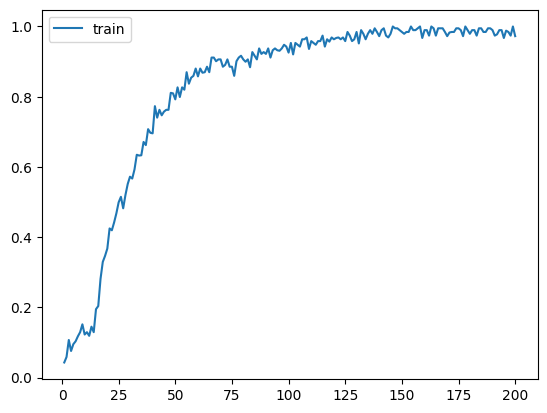

In [58]:
epoch_count = range(1, len(history1['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=history1['accuracy'], label='train')
plt.show()

### 6 - Testing y validación

In [59]:
def text_to_tokens(text):
    lemma_tokens = []
    tokens = nlp(preprocess_clean_text(text.lower()))
    for token in tokens:
        lemma_tokens.append(token.lemma_)
    #print(lemma_tokens)
    return lemma_tokens

def bag_of_words(text, vocab):
    tokens = text_to_tokens(text)
    bow = [0] * len(vocab)
    for w in tokens:
        for idx, word in enumerate(vocab):
            if word == w:
                bow[idx] = 1
    #print(bow)
    return np.array(bow)

def pred_class(text, vocab, labels):
    bow = bag_of_words(text, vocab)
    words_recognized = sum(bow)

    return_list = []
    if words_recognized > 0:
        x = torch.from_numpy(np.array([bow]).astype(np.float32))
        result = model1(x)[0].detach().numpy()
        thresh = 0.2
        y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]
        y_pred.sort(key=lambda x: x[1], reverse=True)

        for r in y_pred:
            return_list.append(labels[r[0]])
            #print(labels[r[0]], r[1])

    return return_list

def get_response(intents_list, intents_json):
    tag = random.choice(intents_list)
    list_of_intents = intents_json["intents"]
    for i in list_of_intents:
        if i["tag"] == tag:
          # Se agrega esta distincion para los mensajes de saludo y despedida que son varios
          if type(i['responses']) == list:
            result = "BOT: " + random.choice(i["responses"])
          else:
            result = "BOT: " + i["responses"]

            break
    return result

In [67]:
while True:
    message = input("Consulta: ")
    intents = pred_class(message, words, classes)
    if len(intents) > 0:
        result = get_response(intents, dataset)
        print(result)
        print()
    else:
        print("Perdón, no comprendo la pregunta.")
        print()

Consulta: Hola!
BOT: Hola!

Consulta: cuanto tiempo antes tengo que presentar el informe del trabajo final?
BOT: El Trabajo Final debe presentarse idealmente al finalizar el quinto bimestre, esto en caso de que el alumno opte por comenzar su Trabajo Final en el primer bimestre, para lo cual el alumno debe definir su tema de Trabajo Final antes del primer bimestre y cursar Gestión de Proyectos o Gestión de la Tecnología y la Innovación en el segundo bimestre, según corresponda. En caso optar por definir su tema de Trabajo Final más adelante, o de no llegar a presentarlo en el quinto bimestre, se puede presentar en las distintas instancias del Taller de Trabajo Final que se habiliten luego del quinto bimestre. El Trabajo Final no se puede presentar una vez superado el plazo de 10 (diez) bimestres indicado en el Art. 7o.

Consulta: Cuando debe presentarse idealmente el trabajo final?
BOT: El Trabajo Final debe presentarse idealmente al finalizar el quinto bimestre, esto en caso de que el 

KeyboardInterrupt: ignored

### 7 - Conclusiones
El bot tal cual está definido es capaz de responder a bastantes tipos de preguntas con gran precisión.

Lo que si se observa una limitación al uso de palabras literales, no tiene capacidad de comprender intensiones o conceptos generales.